In [202]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import ipywidgets as widgets
from IPython.display import display
from IPython.display import display, clear_output

In [144]:
data_dict_path = "/Users/test/Desktop/code/METAL-AI/data/computerome_backup_data.pkl"
# Use 'rb' to read in binary mode
with open(data_dict_path, 'rb') as file:
    data_dict = pickle.load(file)

In [211]:


# Dropdown menu setup for Atom and Ionization state

element_names = {
    1: "Hydrogen", 2: "Helium", 3: "Lithium", 4: "Beryllium", 5: "Boron",
    6: "Carbon", 7: "Nitrogen", 8: "Oxygen", 9: "Fluorine", 10: "Neon",
    11: "Sodium", 12: "Magnesium", 13: "Aluminum", 14: "Silicon", 15: "Phosphorus",
    16: "Sulfur", 17: "Chlorine", 18: "Argon", 19: "Potassium", 20: "Calcium",
    21: "Scandium", 22: "Titanium", 23: "Vanadium", 24: "Chromium", 25: "Manganese",
    26: "Iron", 27: "Cobalt", 28: "Nickel", 29: "Copper", 30: "Zinc",
    31: "Gallium", 32: "Germanium", 33: "Arsenic", 34: "Selenium", 35: "Bromine",
    36: "Krypton", 37: "Rubidium", 38: "Strontium", 39: "Yttrium", 40: "Zirconium",
    41: "Niobium", 42: "Molybdenum", 43: "Technetium", 44: "Ruthenium", 45: "Rhodium",
    46: "Palladium", 47: "Silver", 48: "Cadmium", 49: "Indium", 50: "Tin",
    51: "Antimony", 52: "Tellurium", 53: "Iodine", 54: "Xenon", 55: "Cesium",
    56: "Barium", 57: "Lanthanum", 58: "Cerium", 59: "Praseodymium", 60: "Neodymium",
    61: "Promethium", 62: "Samarium", 63: "Europium", 64: "Gadolinium", 65: "Terbium",
    66: "Dysprosium", 67: "Holmium", 68: "Erbium", 69: "Thulium", 70: "Ytterbium",
    71: "Lutetium", 72: "Hafnium", 73: "Tantalum", 74: "Tungsten", 75: "Rhenium",
    76: "Osmium", 77: "Iridium", 78: "Platinum", 79: "Gold", 80: "Mercury",
    81: "Thallium", 82: "Lead", 83: "Bismuth", 84: "Polonium", 85: "Astatine",
    86: "Radon", 87: "Francium", 88: "Radium", 89: "Actinium", 90: "Thorium",
    91: "Protactinium", 92: "Uranium", 93: "Neptunium", 94: "Plutonium", 95: "Americium",
    96: "Curium", 97: "Berkelium", 98: "Californium", 99: "Einsteinium", 100: "Fermium",
    101: "Mendelevium", 102: "Nobelium", 103: "Lawrencium", 104: "Rutherfordium", 105: "Dubnium",
    106: "Seaborgium", 107: "Bohrium", 108: "Hassium", 109: "Meitnerium", 110: "Darmstadtium",
    111: "Roentgenium", 112: "Copernicium", 113: "Nihonium", 114: "Flerovium", 115: "Moscovium",
    116: "Livermorium", 117: "Tennessine", 118: "Oganesson"
}
keys = data_dict.keys()
# Dropdown for Atoms
unique_atoms = sorted(set(protons for (protons, electrons) in keys if protons in element_names))
atom_dropdown = widgets.Dropdown(options=[(element_names[atom], atom) for atom in unique_atoms], description='Atom:',)

# atom_data = {(protons, electrons): {"Converged": electrons % 2 == 0}
#              for (protons, electrons) in keys if protons in element_names}

# Function to generate ion name based on charge
def generate_ion_name(protons, electrons):
    charge = protons - electrons
    return f"{charge:+}" if charge != 0 else "Neutral"

# Generating atom_data with descriptive labels
atom_data = {(protons, electrons):  generate_ion_name(protons, electrons)
             for (protons, electrons) in keys if protons in element_names}


# Dropdown for Ionization states
ion_dropdown = widgets.Dropdown(description='Ionization:',)
def update_ions(*args):
    n_protons = atom_dropdown.value
    ions = [(atom_data[(n_protons, e)], e) for (p, e) in keys if p == n_protons]
    ion_dropdown.options = ions

atom_dropdown.observe(update_ions, 'value')
update_ions()

# Display widgets
display(atom_dropdown, ion_dropdown)

# Setup output for plots
plot_output = widgets.Output()
display(plot_output)

def update_plot(*args):
    with plot_output:
        clear_output(wait=True)
        G = nx.DiGraph()#ranksep=[0.1,0.1,10,30],voro_margin=1
        line_width_bias = 0.1
        effect_scale = 2
        line_width = 0.3
        
        added_ground_state_node = False

        n_protons, n_electrons = atom_dropdown.value, ion_dropdown.value
        if (n_protons, n_electrons) in data_dict:
            #loop through ASFs smallest to largest
            for key_tuple, value in sorted(data_dict[(n_protons, n_electrons)].items(), key=lambda x: len(x[0])):

                # if the ASF have no previous ASF
                if len(key_tuple) == 2:
                    if not added_ground_state_node:
                        ground_state_node = ()
                        G.add_node(ground_state_node, converged=None)
                        added_ground_state_node = True
                    
                    
                    
                    G.add_node(key_tuple, label=str(key_tuple), converged=value['Converged'])
                    if 'effect' in value:
                        weight = value['effect'][value['index']] *effect_scale
                        if np.isnan(weight):
                            weight = line_width
                    else:
                        weight = line_width
                    print(value['index'])
                    edge_label =', '.join(f"{num}^{cnt}" if cnt > 1 else f"{num}" for num, cnt in Counter(value['excitations'][value['index']]).items() if num != 0)
                    G.add_edge(ground_state_node, key_tuple, color='red',weight=weight,label=edge_label)

                    # G.add_edge(root, prev_node, color='red',weight=weight,label=value['excitations'][not value['index']])
                else:
                    # if the ASF has previous ASFs add node and edge to previous ASF
                    G.add_node(key_tuple, label=str(key_tuple), converged=value['Converged'])
                    if 'effect' in value:
                        weight = value['effect'][value['index']] *effect_scale
                        if np.isnan(weight):
                            weight = line_width
                    else:
                        weight = line_width
                    edge_label =', '.join(f"{num}^{cnt}" if cnt > 1 else f"{num}" for num, cnt in Counter(value['excitations'][value['index']]).items() if num != 0)
                    G.add_edge(key_tuple[:value['index']] + key_tuple[value['index']+1:], key_tuple, label=edge_label, color='red',weight=weight)

                # loop over all other ASFs and add edges between potential previous ASFs
                for i in range(len(key_tuple)):
                    if i != value['index']:
                        if key_tuple[:i] + key_tuple[i+1:] in G:
                            G.add_edge(key_tuple[:i] + key_tuple[i+1:], key_tuple, color='grey',weight=0)

        color_map = ['lightgray' if node_info['converged'] is None else 'blue' if node_info['converged'] else 'red'
                     for node, node_info in G.nodes(data=True)]
        edge_colors = nx.get_edge_attributes(G,'color').values()
        # # edge_color=edge_colors
        width = [weight +line_width_bias for weight in nx.get_edge_attributes(G,'weight').values()]

        edge_labels = nx.get_edge_attributes(G, 'label') 
        # print(ground_state_node)
        pos = nx.nx_agraph.graphviz_layout(G, prog='twopi',root=ground_state_node)
        plt.figure(figsize=(8, 8))
        nx.draw(G, pos, node_color=color_map, edge_color=edge_colors,width=width, node_size=300, alpha=0.9, arrowsize=20, arrowstyle='-|>')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,font_size=7)

        plt.show()

ion_dropdown.observe(update_plot, 'value')

Dropdown(description='Atom:', options=(('Helium', 2), ('Lithium', 3), ('Beryllium', 4), ('Boron', 5), ('Carbon…

Dropdown(description='Ionization:', options=(('Neutral', 2),), value=None)

Output()

In [236]:
data_dict_path = "/Users/test/Desktop/code/METAL-AI/data/data_dict1.pkl"
# Use 'rb' to read in binary mode
with open(data_dict_path, 'rb') as file:
    data_dict = pickle.load(file)

keys = data_dict.keys()
# Dropdown for Atoms
unique_atoms = sorted(set(protons for (protons, electrons) in keys if protons in element_names))
atom_dropdown = widgets.Dropdown(options=[(element_names[atom], atom) for atom in unique_atoms], description='Atom:',)

# Function to generate ion name based on charge
def generate_ion_name(protons, electrons):
    charge = protons - electrons
    return f"{charge:+}" if charge != 0 else "Neutral"

# Generating atom_data with descriptive labels
atom_data = {(protons, electrons):  generate_ion_name(protons, electrons)
             for (protons, electrons) in keys if protons in element_names}


# Dropdown for Ionization states
ion_dropdown = widgets.Dropdown(description='Ionization:',)
def update_ions(*args):
    n_protons = atom_dropdown.value
    ions = [(atom_data[(n_protons, e)], e) for (p, e) in keys if p == n_protons]
    ion_dropdown.options = ions

atom_dropdown.observe(update_ions, 'value')
update_ions()

# Display widgets
display(atom_dropdown, ion_dropdown)

# Setup output for plots
plot_output = widgets.Output()
display(plot_output)

def node_color(converged):
    if converged is None:
        return 'lightgray'
    elif converged:
        return 'blue'
    else:
        return 'red'

def update_plot(*args):
    with plot_output:
        clear_output(wait=True)
        G = nx.DiGraph(ranksep=10)#ranksep=[0.1,0.1,10,30],voro_margin=1
        line_width_bias = 0.1
        effect_scale = 2
        line_width = 0.3
        base_weight = 3
        base_effect = 0.3
        
        added_ground_state_node = False

        n_protons, n_electrons = atom_dropdown.value, ion_dropdown.value
        if (n_protons, n_electrons) in data_dict:
            #loop through ASFs smallest to largest
            for key_tuple, value in sorted(data_dict[(n_protons, n_electrons)].items(), key=lambda x: len(x[0])):

                # if the ASF have no previous ASF
                if len(key_tuple) == 2:
                    if not added_ground_state_node:
                        ground_state_node = ()
                        G.add_node(ground_state_node, converged=None)
                        added_ground_state_node = True
                    
                    
                    # print(value['converged'])
                    # print(np.any(value['converged']))
                    G.add_node(key_tuple, label=str(key_tuple), converged=np.any(value['converged']==True))
                    for i, converged in enumerate(value['converged']):
                        if not np.isnan(converged):
                            edge_label =', '.join(f"{num}^{cnt}" if cnt > 1 else f"{num}" for num, cnt in Counter(value['excitations'][i]).items() if num != 0)
                            G.add_edge(ground_state_node, key_tuple, converged = converged, effect = base_effect, weight=base_weight,label=edge_label)

                    # G.add_edge(root, prev_node, color='red',weight=weight,label=value['excitations'][not value['index']])
                else:
                    # if the ASF has previous ASFs add node and edge to previous ASF
                    # print(value['converged'])
                    # print(np.any(value['converged']))
                    G.add_node(key_tuple, label=str(key_tuple), converged=np.any(value['converged']==True))

                    for i, converged in enumerate(value['converged']):
                        if not np.isnan(converged):
                            edge_label =', '.join(f"{num}^{cnt}" if cnt > 1 else f"{num}" for num, cnt in Counter(value['excitations'][i]).items() if num != 0)
                            if 'effect' in value:
                                effect = value['effect'][i] *effect_scale
                                if np.isnan(effect):
                                    effect = base_effect
                            else:
                                effect = base_effect
                            G.add_edge( key_tuple[:i] + key_tuple[i+1:], key_tuple, label=edge_label, converged = converged, effect = effect, weight=base_weight)
                        else:
                            if key_tuple[:i] + key_tuple[i+1:] in G:
                                if np.any(value['converged']==True):
                                    G.add_edge(key_tuple[:i] + key_tuple[i+1:], key_tuple, effect = base_effect, converged = None, weight=0)

                    

        color_map = ['lightgray' if node_info['converged'] is None else 'green' if node_info['converged'] else 'red'
                     for node, node_info in G.nodes(data=True)]


        edge_colors = ['lightgray' if edge_color is None else 'green' if edge_color else 'red' for edge_color in nx.get_edge_attributes(G,'converged').values()]

        # # edge_color=edge_colors
        width = [effect + 0.1 for effect in nx.get_edge_attributes(G,'effect').values()]

        edge_labels = nx.get_edge_attributes(G, 'label') 
        # print(ground_state_node)
        pos = nx.nx_agraph.graphviz_layout(G, prog='twopi',root=ground_state_node)
        plt.figure(figsize=(8, 8))
        nx.draw(G, pos, node_color=color_map, edge_color=edge_colors,width=width, node_size=300, alpha=0.9, arrowsize=20, arrowstyle='-|>')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,font_size=7)

        plt.show()

ion_dropdown.observe(update_plot, 'value')
# make grey lines only between converged nodes

Dropdown(description='Atom:', options=(('Helium', 2), ('Lithium', 3), ('Beryllium', 4), ('Boron', 5), ('Carbon…

Dropdown(description='Ionization:', options=(('Neutral', 2),), value=None)

Output()

In [210]:
for ion_key in data_dict.keys():
    for asf_key in data_dict[ion_key].keys():
        if len(asf_key) == 2:
            print(asf_key)

((2, 2, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (2, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))
((2, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (2, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))
((2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (2, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))
((2, 2, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (2, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))
((2, 2, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (2, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))
((2, 2, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (2, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))
((2, 2, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

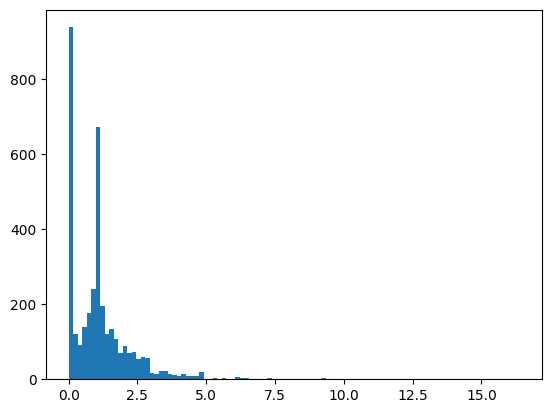

In [169]:

effect_list = []
for ion_key in data_dict.keys():
    for asf_key in data_dict[ion_key].keys():
        if 'effect' in data_dict[ion_key][asf_key]:
            [x for x in np.isnan(data_dict[ion_key][asf_key]['effect'])]
            # if data_dict[ion_key][asf_key]['effect']:
            effect =[x for x in data_dict[ion_key][asf_key]['effect'] if not np.isnan(x)]
            effect_list.extend(effect)
            # effect_list + effect
_ = plt.hist(effect_list, bins=100)

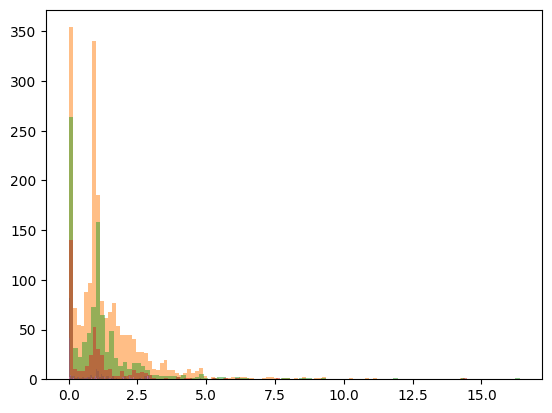

In [172]:
effect_by_depth = {}
for ion_key in data_dict.keys():
    for asf_key in data_dict[ion_key].keys():
        if 'effect' in data_dict[ion_key][asf_key]:
            if len(asf_key) not in effect_by_depth:
                effect_by_depth[len(asf_key)] = []
            effect_by_depth[len(asf_key)].extend([x for x in data_dict[ion_key][asf_key]['effect'] if not np.isnan(x)])
            # [x for x in np.isnan(data_dict[ion_key][asf_key]['effect'])]
            # # if data_dict[ion_key][asf_key]['effect']:
            # effect =
            # effect_list.extend(effect)
for depth in effect_by_depth.keys():
    _ = plt.hist(effect_by_depth[depth], bins=100, alpha=0.5, label=f"Depth {depth}")


In [241]:
import scipy as sp
binomial = sp.stats.binom(10,2)
print(binomial.pdf)

AttributeError: module 'scipy.stats' has no attribute 'Binom'

(array([939., 120.,  91., 139., 178., 242., 672., 195., 122., 133., 108.,
         69.,  88.,  70.,  74.,  53.,  60.,  56.,  18.,  14.,  23.,  23.,
         13.,  12.,   9.,  14.,   9.,  10.,  10.,  20.,   2.,   1.,   4.,
          2.,   3.,   2.,   2.,   5.,   3.,   3.,   2.,   0.,   0.,   1.,
          3.,   2.,   1.,   2.,   2.,   0.,   1.,   2.,   2.,   1.,   0.,
          2.,   3.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([8.65425547e-55, 1.63875581e-01, 3.27751163e-01, 4.91626744e-01,
        6.55502326e-01, 8.19377907e-01, 9.83253488e-01, 1.14712907e+00,
        1.31100465e+00, 1.47488023e+00, 1.63875581e+00, 1.80263140e+00,
        1.96650698e+00, 2.13038256e+00, 2.29425814e+00, 2.45813372e+00,
        2.62200930e+00, 2.7858

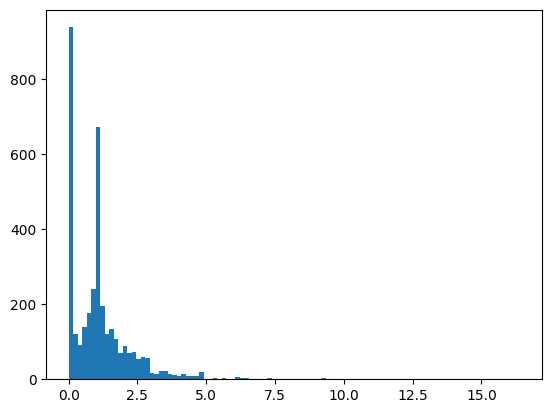

In [168]:
plt.hist(effect_list, bins=100)

In [10]:
data_dict[(11, 9)].keys()
data_dict[(11, 9)][((2, 2, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (2, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))]

{'excitations': ((0, 0, 0, 5), (0, 0, 0, 0)),
 'index': 0,
 'Converged': True,
 'effect': array([nan, nan])}

In [151]:
atom_data

{(11, 9): '+2',
 (21, 21): 'Neutral',
 (23, 21): '+2',
 (16, 13): '+3',
 (87, 86): '+1',
 (73, 70): '+3',
 (55, 54): '+1',
 (20, 17): '+3',
 (49, 47): '+2',
 (26, 25): '+1',
 (24, 23): '+1',
 (16, 14): '+2',
 (50, 48): '+2',
 (24, 22): '+2',
 (74, 73): '+1',
 (7, 5): '+2',
 (8, 7): '+1',
 (34, 31): '+3',
 (70, 70): 'Neutral',
 (5, 5): 'Neutral',
 (72, 72): 'Neutral',
 (22, 19): '+3',
 (24, 21): '+3',
 (75, 75): 'Neutral',
 (71, 70): '+1',
 (3, 3): 'Neutral',
 (74, 74): 'Neutral',
 (77, 75): '+2',
 (47, 46): '+1',
 (77, 77): 'Neutral',
 (84, 81): '+3',
 (53, 53): 'Neutral',
 (7, 7): 'Neutral',
 (80, 78): '+2',
 (54, 53): '+1',
 (52, 50): '+2',
 (57, 56): '+1',
 (41, 40): '+1',
 (12, 9): '+3',
 (47, 44): '+3',
 (38, 36): '+2',
 (6, 4): '+2',
 (15, 13): '+2',
 (40, 38): '+2',
 (67, 67): 'Neutral',
 (9, 6): '+3',
 (69, 69): 'Neutral',
 (60, 59): '+1',
 (79, 79): 'Neutral',
 (45, 45): 'Neutral',
 (28, 25): '+3',
 (46, 46): 'Neutral',
 (9, 8): '+1',
 (75, 72): '+3',
 (74, 71): '+3',
 (61, 59

In [12]:
summary_stats = {}
for ion_key in data_dict.keys():
    n_converged = 0
    for asf_key in data_dict[ion_key].keys():
        
        data_dict[ion_key][asf_key]
        if data_dict[ion_key][asf_key]['Converged']:
            n_converged += 1
    summary_stats[ion_key] = n_converged

    

In [140]:
def generate_ion_name(protons, electrons):
    charge = protons - electrons 
    return f"{charge:+}" if charge != 0 else "Neutral"

# Generating atom_data with descriptive labels
atom_data2 = {(protons, electrons): f"{element_names[protons]} {generate_ion_name(protons, electrons)}"
             for (protons, electrons) in keys if protons in element_names}
print(atom_data2)

{(11, 9): 'Sodium +2', (21, 21): 'Scandium Neutral', (23, 21): 'Vanadium +2', (16, 13): 'Sulfur +3', (87, 86): 'Francium +1', (73, 70): 'Tantalum +3', (55, 54): 'Cesium +1', (20, 17): 'Calcium +3', (49, 47): 'Indium +2', (26, 25): 'Iron +1', (24, 23): 'Chromium +1', (16, 14): 'Sulfur +2', (50, 48): 'Tin +2', (24, 22): 'Chromium +2', (74, 73): 'Tungsten +1', (7, 5): 'Nitrogen +2', (8, 7): 'Oxygen +1', (34, 31): 'Selenium +3', (70, 70): 'Ytterbium Neutral', (5, 5): 'Boron Neutral', (72, 72): 'Hafnium Neutral', (22, 19): 'Titanium +3', (24, 21): 'Chromium +3', (75, 75): 'Rhenium Neutral', (71, 70): 'Lutetium +1', (3, 3): 'Lithium Neutral', (74, 74): 'Tungsten Neutral', (77, 75): 'Iridium +2', (47, 46): 'Silver +1', (77, 77): 'Iridium Neutral', (84, 81): 'Polonium +3', (53, 53): 'Iodine Neutral', (7, 7): 'Nitrogen Neutral', (80, 78): 'Mercury +2', (54, 53): 'Xenon +1', (52, 50): 'Tellurium +2', (57, 56): 'Lanthanum +1', (41, 40): 'Niobium +1', (12, 9): 'Magnesium +3', (47, 44): 'Silver +3'